In [148]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
import re
import requests
from PIL import Image 
import pytesseract

In [149]:
# -1. 회전도 측정
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter

def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

image = cv2.imread('sample_input/page_0.jpg')
angle, corrected = correct_skew(image)
print('Skew angle:', angle)
    

/var/folders/g0/2ghmttp54jn6fs6ph3b96_fc0000gn/T/ipykernel_29265/3694213040.py:8: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


Skew angle: 0


Text(0.5, 1.0, 'Sharp Image')

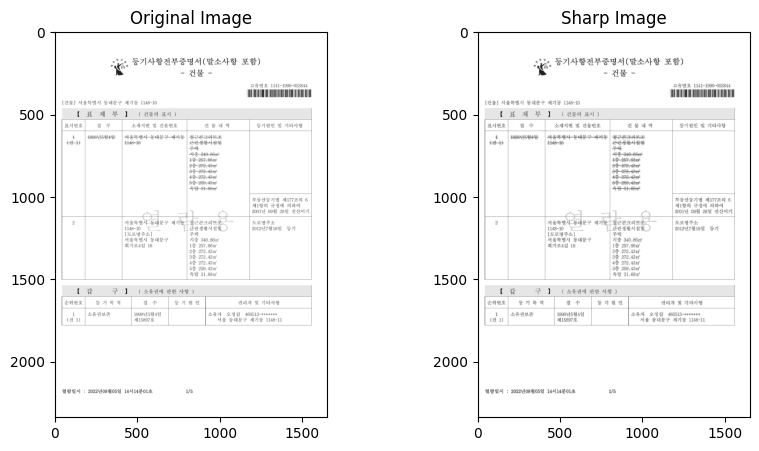

In [150]:
# 0. 이미지 선명하게 표현 (사용하지 않음)

# 대상 픽셀을 강조하는 커널을 정의한 후 filter2D() 메소드를 사용하여 이미지에 적용한다.

image = cv2.imread('sample_input/page_0.jpg', cv2.IMREAD_GRAYSCALE)

# 커널 생성(대상이 있는 픽셀을 강조)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 커널 적용 
image_sharp = cv2.filter2D(image, -1, kernel)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_sharp, cmap='gray')
ax[1].set_title('Sharp Image')

높이, 폭 출력 : (2339, 1653)
로고 템플릿 매칭도 : [0.7078022360801697, (322, 147), 132, 126]
바코드 템플릿 매칭도 : [0.514758825302124, (1158, 345), 397, 55]


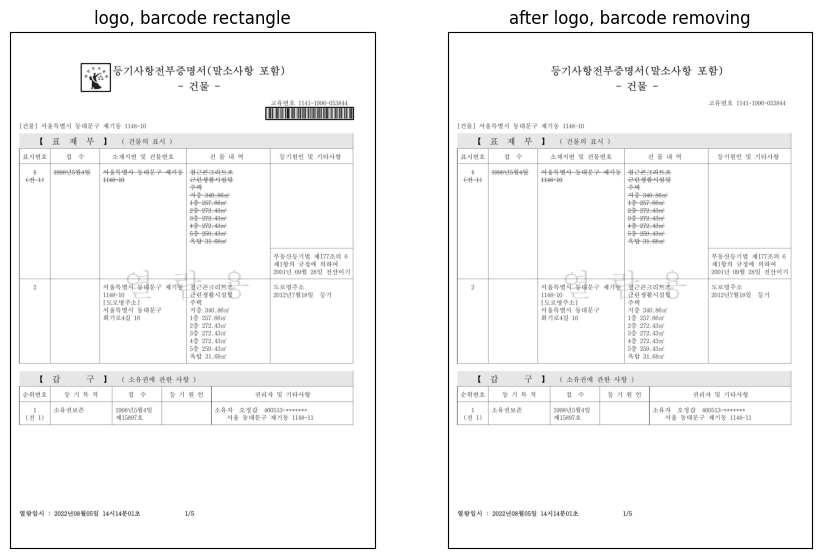

In [151]:
# 1.로고랑 바코드 크기 조정해서 템플릿 영역 없애기

# input 이미지의 폭에 기준해 템플릿 크기 조정
img2 = image
print('높이, 폭 출력 : '+str(img2.shape)) 

startIdx = img2.shape[1] / 15000
endIdx = img2.shape[1] / 6000

startIdx2 = img2.shape[1] / 5000
endIdx2 = img2.shape[1] / 3500

findValue = None
findValue2 = None


for scale in np.linspace(startIdx,endIdx,20)[::-1]:
    template = cv2.imread('template/logo.png', 0)
    template = cv2.resize(template,dsize=(0, 0), fx=scale,fy=scale)

    w, h = template.shape[::-1]
    
    result = cv2.matchTemplate(img2, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    if findValue == None:
        findValue = [max_val,max_loc,w,h]
    else:
        if(findValue[0] < max_val):
            findValue = [max_val,max_loc,w,h]    

print('로고 템플릿 매칭도 : '+str(findValue))
startX, startY = findValue[1][0],findValue[1][1] # 만약 cv.TM_SQDIFF 혹은 cv.TM_SQDIFF_NORMED를 사용했을경우 최솟값을 사용해야한다.
endX, endY = startX + findValue[2], startY + findValue[3]
cv2.rectangle(img2, (startX, startY), (endX, endY), (0,0,255), 3)


for scale in np.linspace(startIdx2,endIdx2,20)[::-1]:
    template = cv2.imread('template/barcode.png', 0)
    template = cv2.resize(template,dsize=(0, 0), fx=scale,fy=scale)

    w, h = template.shape[::-1]
    
    result = cv2.matchTemplate(img2, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    if findValue2 == None:
        findValue2 = [max_val,max_loc,w,h]
    else:
        if(findValue2[0] < max_val):
            findValue2 = [max_val,max_loc,w,h]    

print('바코드 템플릿 매칭도 : '+str(findValue2))
startX, startY = findValue2[1][0],findValue2[1][1] # 만약 cv.TM_SQDIFF 혹은 cv.TM_SQDIFF_NORMED를 사용했을경우 최솟값을 사용해야한다.
endX, endY = startX + findValue2[2], startY + findValue2[3]
cv2.rectangle(img2, (startX, startY), (endX, endY), (0,0,255), 3)



pltshow = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1), plt.imshow(pltshow)
plt.title('logo, barcode rectangle')
plt.xticks([]), plt.yticks([])

image = cv2.imread('sample_input/page_0.jpg', cv2.IMREAD_GRAYSCALE)
image_sharp = cv2.filter2D(image, -1, kernel)
img2 = image

startX, startY = findValue[1][0],findValue[1][1] # 만약 cv.TM_SQDIFF 혹은 cv.TM_SQDIFF_NORMED를 사용했을경우 최솟값을 사용해야한다.
endX, endY = startX + findValue[2], startY + findValue[3]

cv2.rectangle(img2, (startX, startY), (endX, endY), (255,255,255), -1)

startX, startY = findValue2[1][0],findValue2[1][1] # 만약 cv.TM_SQDIFF 혹은 cv.TM_SQDIFF_NORMED를 사용했을경우 최솟값을 사용해야한다.
endX, endY = startX + findValue2[2], startY + findValue2[3]

cv2.rectangle(img2, (startX, startY), (endX, endY), (255,255,255), -1)
pltshow = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 2), plt.imshow(pltshow)
plt.title('after logo, barcode removing')
plt.xticks([]), plt.yticks([])


plt.show()


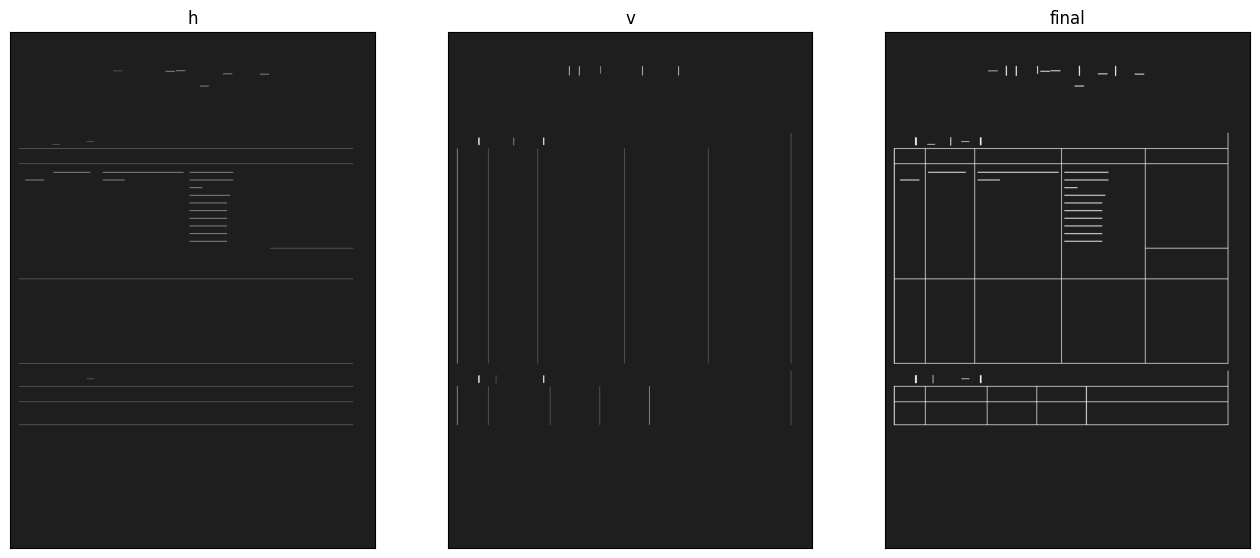

In [152]:
# 2.표 위치 저장과 제거
_,img_bin = cv2.threshold(img2,150,225,cv2.THRESH_BINARY)
img_bin=~img_bin

### 자음 ㅁ이 사각형으로 인식되는 이슈 방지를 위해 selecting min size as  pixels
line_min_width = int(img2.shape[1] / 50)
kernal_h = np.ones((1,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,1), np.uint8)

# Horizontal Kernel, Vertical Kernel
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

# MIX Kernel
img_bin_final=img_bin_h|img_bin_v

final_kernel = np.ones((3,3), np.uint8)
img_bin_final=cv2.dilate(img_bin_final, final_kernel, iterations=1)


imgRGB = cv2.cvtColor(img_bin_h, cv2.COLOR_BGR2RGB)
imgRGB2 = cv2.cvtColor(img_bin_v, cv2.COLOR_BGR2RGB)
imgRGB3 = cv2.cvtColor(img_bin_final, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1), plt.imshow(imgRGB)
plt.title('h')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2), plt.imshow(imgRGB2)
plt.title('v')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 3), plt.imshow(imgRGB3)
plt.title('final')
plt.xticks([]), plt.yticks([])

plt.show()

-- 제거된 표 구역 총 26개


(([], []), ([], []))

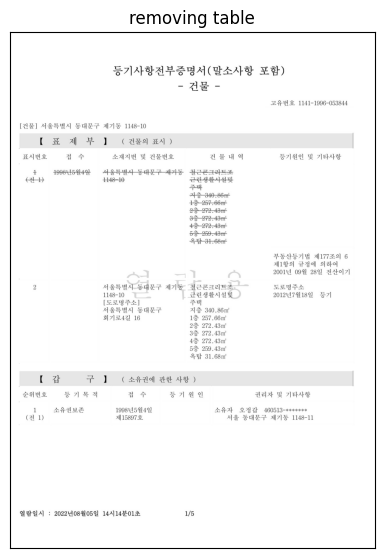

In [153]:
_, labels, tableInfo,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

n1 = np.array(tableInfo[2:])

print('-- 제거된 표 구역 총 {}개'.format(len(tableInfo[2:])))

for x,y,w,h,area in tableInfo[2:]:
        # print(f"x: {x}, y: {y}, w: {w}, h: {h}, pixel: {area}, x+w: {x+w}, y+h: {y+h}")
        cv2.rectangle(img2,(x,y), (x+w, y+h),(255,255,255), 6)

pltshow = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1), plt.imshow(pltshow)
plt.title('removing table')
plt.xticks([]), plt.yticks([])

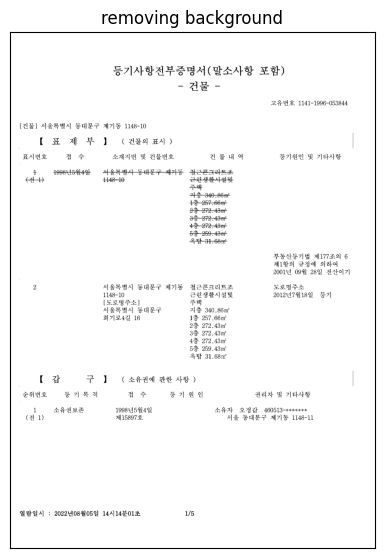

In [154]:
img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# extract bgr channels
bgr = img[:,:,0:3]

# select grayscale range
mask = cv2.inRange(bgr, (0,190,0), (255,255,255))

# change the image to make it green where the mask is white
bgr_new = bgr.copy()

# BGR이라서 255, 0, 0
bgr_new[mask!=255] = (255,255,255)


rgbImg = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1), plt.imshow(rgbImg)
plt.title('removing background')
plt.xticks([]), plt.yticks([])


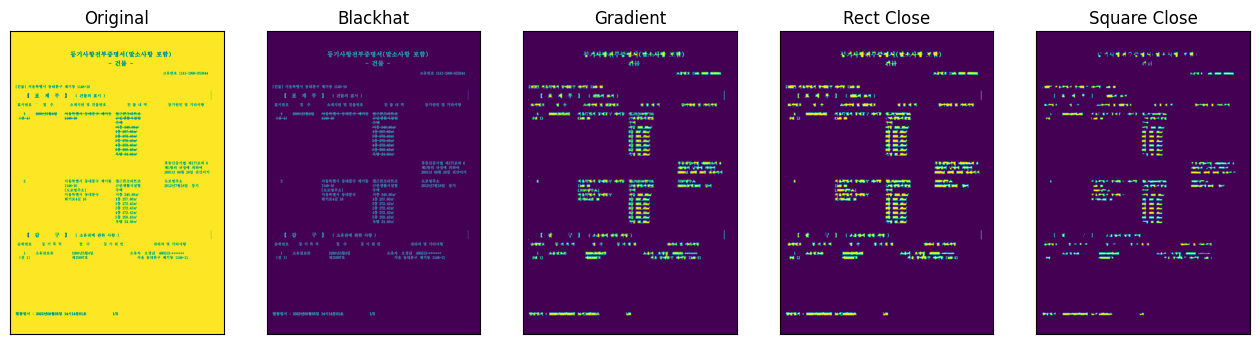

In [155]:
# 잡음 제거
img = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2GRAY)

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
 
# gray = cv2.GaussianBlur(gray, (1, 1), 0)
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKernel)
 
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
 
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
close_thresh = cv2.erode(close_thresh, None, iterations=2)
 
plt.figure(figsize=(16,10))
plt.subplot(1, 5, 1), plt.imshow(img)
plt.title("Original")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 5, 2), plt.imshow(blackhat)
plt.title("Blackhat")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 5, 3), plt.imshow(grad)
plt.title( "Gradient")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 5, 4), plt.imshow(thresh)
plt.title("Rect Close")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 5, 5), plt.imshow(close_thresh)
plt.title( "Square Close")
plt.xticks([]), plt.yticks([])

plt.show()

In [156]:
# Tesseract OCR 실행
custom_config = '--psm 6 --tessdata-dir "src/"'
merge_Img_text = pytesseract.image_to_data(img ,lang='kor',output_type='data.frame',config= custom_config)


In [157]:
print(merge_Img_text)

     level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        1         1          0        0         0         0     0     0   
1        2         1          1        0         0         0    45   157   
2        3         1          1        1         0         0    45   157   
3        4         1          1        1         1         0   472   158   
4        5         1          1        1         1         1   472   159   
..     ...       ...        ...      ...       ...       ...   ...   ...   
325      5         1          1        1        31        14   479  2172   
326      5         1          1        1        31        15   512  2170   
327      5         1          1        1        31        16   535  2172   
328      5         1          1        1        31        17   566  2172   
329      5         1          1        1        31        18   794  2170   

     width  height       conf text  
0     1653    2339  -1.000000  NaN  
1     1509   

In [158]:
# 실행 결과 데이터 처리
truedata = merge_Img_text.dropna(subset=['text'],axis=0)

array = truedata.to_numpy()
line_num = 1
result = []
word = []
colline = []
collist = []


for data in array:
    if(data[4]==line_num):
        if(len(colline)==0):
            word.append(data[11])
        else:
            for i in range(len(colline)-1):
                if(colline[i]<data[6]<colline[i+1]):
                    collist[i//2].append(data[11])
        
    else :
        if(len(collist)==0):
            result.append(word)
        else :
            result.append(collist)

        word = [data[11]]
        colline=[]
        line_num = data[4]
        for tabledata in tableInfo[2:]:
            x,y,w,h,_ = tabledata
            if(y<data[7]<y+h):
                colline.append(x)
                colline.append(x+w)
        colline = list(set(colline))
        colline.sort()
        
        collist = [[] for i in range(len(colline)//2)]
        if len(collist) != 0:
            collist[0].append(data[11])


In [159]:
text = []
for i in result:
    if not isinstance(i[0], list):
        print(''.join(i))
    else:
        for j in i:
            print(''.join(j))
    

는중브즈로중
능기사항전부증명서(말소사항포함)
그
-건물-
고유번호1141-1996-053844
[건물]서울특별시동대문구제기동1148-10
[표제부】(건물의표시)|
표시번호
접수
소재지번및건물번호
건물내역
둥기원인및기타사항
3998
년5월4알、
사울특별서-동타문구-체거동
찰근콘그라트조

<존늄

48-16
근란생활사솔맞

64




지층


340-86눈

옥


톱-3ㄴ68분

부



동산등기법제177조의6
제



1항의규정에의하여
2001



년09월28일전산이기
3

서울특별시동대문구제기동
철근콘크리트조
도로명주소
1148-10


근린생활시설및
2012년7월18일등기
[

도로명주소]
주택

서

울특별시동대문구
지층340.86ㅁ

회

기로4길16
1충357.66표

2


충279.43나

3


층2792.43

4


층279.43나

5


충259.43나

옥


탐31.68뇨

[감구】 (소유권에관한사항)
순위번호
둥기목적
접수
등기원인
권리자및기타사항
1
소유권보존
1998년5월4일

소유자오정감.460513-##**※##※
(전1)

제15897호

서울동대문구제기동1148-11
